# 01__hit_expression

in this notebook, i join enrichment data with expression data and look into how the two are related. i also create a set of stringent non hits to serve as a comparison to screen hits.

figures in this notebook:
- Fig 5G: volcano plot showing log2 foldchange in expression from RNA-seq with hits from our screen highlighted (looking only at stringent non hits)
- Fig 7A: plot showing differential expression of the 6 hits predicted to have RNA mechanisms

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from enrich_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
rna_seq_f = "../../../data/00__rna_seq/01__processed_results/rna_seq_results.tsv"

In [4]:
index_f = "../../../data/01__design/02__final_sgRNAs/crispri_picked_sgRNAs.not_deduped.txt"

In [5]:
data_f = "../../../data/02__screen/02__enrichment_data/SuppTable_S3.CRISPhieRmix_results.txt"

In [6]:
closest_mrnas_f = "../../../misc/00__gene_metadata/gencode.v25lift37.mRNA_TSS_within_1000bp_lncRNA_TSS.txt"

## 1. import data

In [7]:
rna_seq = pd.read_table(rna_seq_f, sep="\t")
rna_seq.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,meso_rep2,hESC_mean,endo_mean,meso_mean,overall_mean,threshold,qval_hESC_endo,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc
0,DIGIT,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.000000,0.025422,4.907468,4.784695,...,0.014741,0.012711,4.846082,0.007370,1.622054,expressed,0.008168525422325441,sleuth NA,2.529248,-0.007628
1,ENST00000000233.9_1,ENSG00000004059.10_2,ARF5,protein_coding,protein_coding,protein_coding,101.476958,102.386195,222.677573,197.586091,...,245.318970,101.931577,210.131832,204.374142,172.145850,expressed,0.0057874417654439295,0.0346694249326972,1.036458,0.996569
2,ENST00000000412.3,ENSG00000003056.3,M6PR,protein_coding,protein_coding,protein_coding,49.696030,46.457026,31.608496,36.350968,...,10.951882,48.076528,33.979732,20.552771,34.203010,expressed,0.00549724038022104,0.13894723887027402,-0.488514,-1.187160
3,ENST00000000442.10_1,ENSG00000173153.13_2,ESRRA,protein_coding,protein_coding,protein_coding,1.924618,3.493033,3.499700,2.419880,...,7.769760,2.708826,2.959790,7.600094,4.422903,expressed,0.814911561863725,0.0241642757995681,0.094461,1.213390
4,ENST00000001008.5_1,ENSG00000004478.7_1,FKBP4,protein_coding,protein_coding,protein_coding,71.840722,79.489420,33.770398,33.810736,...,68.012268,75.665071,33.790567,61.985019,57.146886,expressed,0.00160853874236564,0.0935556001786738,-1.139873,-0.283561


In [8]:
data = pd.read_table(data_f, sep="\t")
data.head()

,group_id,transcript_name,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA
0,NC_000003.12:-:27722707,EOMES-004,control,protein_coding,0.0,6.092888,hit,6
1,NC_000019.10:+:11060127,SMARCA4-014,mRNA,protein_coding,0.0,1.145824,hit,6
2,NC_000023.11:-:11111137,"[RP11-120D5.1-005, RP11-120D5.1-004]",experimental,promoter_overlap,0.0,4.142174,hit,7
3,NC_000020.11:+:37095770,RP4-621N11.2-001,experimental,promoter_overlap,0.0,0.626713,hit,5
4,NC_000011.10:+:90223166,RP11-121L10.2-001,experimental,promoter_overlap,0.0,5.297966,hit,8


In [9]:
index = pd.read_table(index_f)
print(len(index))
print(len(index.tss_id.unique()))

129351
10719


In [10]:
closest_mrnas = pd.read_table(closest_mrnas_f, sep="\t", header=None)
closest_mrnas.columns = ["lncrna_enst", "lncrna_name", "mrna_enst", "mrna_name"]
closest_mrnas.head()

,lncrna_enst,lncrna_name,mrna_enst,mrna_name
0,ENST00000493797.1_1,RP11-34P13.14,ENST00000423372.3,AL627309.1
1,ENST00000458555.1_1,RP11-54O7.11,ENST00000379389.4_2,ISG15
2,ENST00000379317.1_1,TTLL10-AS1,ENST00000379288.3_1,TTLL10
3,ENST00000379317.1_1,TTLL10-AS1,ENST00000460998.1_1,TTLL10
4,ENST00000379317.1_1,TTLL10-AS1,ENST00000514695.1_1,TTLL10


## 2. merge enrichment data (which is grouped by TSS group, which can target multiple transcripts) with transcript-level information in index (in order to merge w/ RNA-seq)
since some TSS groups target multiple transcripts, split these up so that we can easily join with the RNA-seq data on transcript_id

In [11]:
index_sub = index[["tss_id", "gene_name", "gene_id", "transcript_name", "transcript_id"]].drop_duplicates()
print(len(index_sub))
print(len(index_sub.tss_id.unique()))
index_sub.head()

12933
10719


,tss_id,gene_name,gene_id,transcript_name,transcript_id
0,NC_000001.11:+:100894913,RP4-549L20.3,ENSG00000273204.1_1,RP4-549L20.3-001,ENST00000609247.1_1
10,NC_000001.11:+:100995473,RP11-421L21.2,ENSG00000235795.1_1,RP11-421L21.2-001,ENST00000414686.1_1
20,NC_000001.11:+:101025906,RP11-421L21.3,ENSG00000233184.6_1,RP11-421L21.3-004,ENST00000446527.5_1
21,NC_000001.11:+:101025906,RP11-421L21.3,ENSG00000233184.6_1,RP11-421L21.3-005,ENST00000453011.5_1
40,NC_000001.11:+:101072856,RP11-421L21.3,ENSG00000233184.6_1,RP11-421L21.3-001,ENST00000449473.2_1


In [12]:
print(len(data))
data_split = tidy_split(data, "group_id", sep=",", keep=False)
print(len(data_split))
data_split["group_id"] = data_split["group_id"].str.replace('[', '')
data_split["group_id"] = data_split["group_id"].str.replace(']', '')
data_split["group_id"] = data_split["group_id"].str.replace(' ', '')
data_split.drop("transcript_name", axis=1, inplace=True)
data_split.head(10)

9771
9779


,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA
0,NC_000003.12:-:27722707,control,protein_coding,0.000000e+00,6.092888,hit,6
1,NC_000019.10:+:11060127,mRNA,protein_coding,0.000000e+00,1.145824,hit,6
2,NC_000023.11:-:11111137,experimental,promoter_overlap,0.000000e+00,4.142174,hit,7
3,NC_000020.11:+:37095770,experimental,promoter_overlap,0.000000e+00,0.626713,hit,5
4,NC_000011.10:+:90223166,experimental,promoter_overlap,0.000000e+00,5.297966,hit,8
5,NC_000008.11:+:54457934,control,protein_coding,0.000000e+00,7.776623,hit,7
6,NC_000003.12:-:27722322,control,protein_coding,0.000000e+00,5.470160,hit,6
7,NC_000012.12:-:53999649,experimental,promoter_overlap,0.000000e+00,0.797079,hit,8
8,NC_000005.10:-:173329499,mRNA,protein_coding,3.700743e-17,1.215004,hit,6
9,NC_000003.12:-:38454682,experimental,promoter_overlap,1.332268e-16,3.118909,hit,10


In [13]:
data_sub = data_split[data_split["ctrl_status"] != "scramble"]
len(data_sub)

9779

In [14]:
data_clean = data_sub.merge(index_sub, left_on="group_id", 
                            right_on="tss_id", how="left")
print(len(data_clean))
data_clean.head()

11776


,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA,tss_id,gene_name,gene_id,transcript_name,transcript_id
0,NC_000003.12:-:27722707,control,protein_coding,0.0,6.092888,hit,6,NC_000003.12:-:27722707,EOMES,ENSG00000163508.12_1,EOMES-004,ENST00000461503.2_1
1,NC_000019.10:+:11060127,mRNA,protein_coding,0.0,1.145824,hit,6,NC_000019.10:+:11060127,SMARCA4,ENSG00000127616.17_2,SMARCA4-014,ENST00000586921.1_1
2,NC_000023.11:-:11111137,experimental,promoter_overlap,0.0,4.142174,hit,7,NC_000023.11:-:11111137,RP11-120D5.1,ENSG00000234129.7_1,RP11-120D5.1-004,ENST00000608176.5_1
3,NC_000023.11:-:11111137,experimental,promoter_overlap,0.0,4.142174,hit,7,NC_000023.11:-:11111137,RP11-120D5.1,ENSG00000234129.7_1,RP11-120D5.1-005,ENST00000608916.1_1
4,NC_000020.11:+:37095770,experimental,promoter_overlap,0.0,0.626713,hit,5,NC_000020.11:+:37095770,RP4-621N11.2,ENSG00000269846.1_1,RP4-621N11.2-001,ENST00000598590.1_1


In [15]:
data_clean[pd.isnull(data_clean["transcript_id"])]

,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA,tss_id,gene_name,gene_id,transcript_name,transcript_id


## 3. merge w/ RNA-seq data using transcript_id

In [16]:
data_w_seq = data_clean.merge(rna_seq, on=["gene_name", "gene_id", "transcript_id"], 
                              how="left").sort_values(by="effect_size", ascending=False)
data_w_seq.drop(["meso_mean", "overall_mean", "qval_hESC_meso", "meso_hESC_log2fc"], axis=1, inplace=True)

In [17]:
nulls = data_w_seq[(pd.isnull(data_w_seq["transcript_id"])) & (data_w_seq["ctrl_status"] != "scramble")]
len(nulls)

0

## 4. how many promoter-overlap hits have an mRNA nearby that is expr?

In [18]:
prom_ov_hits = data_w_seq[(data_w_seq["hit_status"] == "hit") & 
                          (data_w_seq["cleaner_transcript_biotype"] == "promoter_overlap") &
                          (data_w_seq["ctrl_status"] == "experimental")][["gene_name", "transcript_name", 
                                                                          "transcript_id", "hESC_mean", 
                                                                          "endo_mean", "endo_hESC_log2fc",
                                                                          "qval_hESC_endo"]]
print(len(prom_ov_hits))

47


In [19]:
## fix digit
prom_ov_hits[prom_ov_hits["gene_name"] == "DIGIT"]

,gene_name,transcript_name,transcript_id,hESC_mean,endo_mean,endo_hESC_log2fc,qval_hESC_endo
78,DIGIT,DIGIT,DIGIT,0.012711,4.846082,2.529248,0.008168525422325441


In [20]:
prom_ov_hits.at[78, "transcript_id"] = "DIGIT_1"

In [21]:
nearby_hit_mrnas = closest_mrnas[closest_mrnas["lncrna_enst"].isin(prom_ov_hits["transcript_id"])]
nearby_hit_mrnas[nearby_hit_mrnas["lncrna_enst"].str.contains("DIGIT")]

,lncrna_enst,lncrna_name,mrna_enst,mrna_name
7547,DIGIT_1,DIGIT,ENST00000238558.4_1,GSC


In [22]:
prom_ov_hits = prom_ov_hits.merge(nearby_hit_mrnas, left_on="transcript_id", right_on="lncrna_enst")
print(len(prom_ov_hits))

186


In [23]:
## now merge mrnas
prom_ov_hits = prom_ov_hits.merge(rna_seq[["transcript_id", "hESC_mean", "endo_mean", "endo_hESC_log2fc",
                                           "qval_hESC_endo"]], left_on="mrna_enst", right_on="transcript_id",
                                  suffixes=("_lncrna", "_mrna"))
print(len(prom_ov_hits))

186


In [24]:
prom_ov_hits_grp = prom_ov_hits.groupby(["transcript_id_lncrna", 
                                         "hESC_mean_lncrna", 
                                         "endo_mean_lncrna",
                                         "endo_hESC_log2fc_lncrna", 
                                         "qval_hESC_endo_lncrna"])[["hESC_mean_mrna",
                                                                    "endo_mean_mrna"]].agg("max").reset_index()
prom_ov_hits_grp.head()

,transcript_id_lncrna,hESC_mean_lncrna,endo_mean_lncrna,endo_hESC_log2fc_lncrna,qval_hESC_endo_lncrna,hESC_mean_mrna,endo_mean_mrna
0,DIGIT_1,0.012711,4.846082,2.529248,0.008168525422325441,0.158873,173.087318
1,ENST00000412067.1_1,0.600637,1.017236,0.333734,0.121358273872493,46.652810,39.052357
2,ENST00000413436.1,0.198609,0.277596,0.092071,0.7050613819713549,234.701165,226.109220
3,ENST00000417820.1_1,0.837844,0.419848,-0.372278,0.0585646169634834,15.277800,11.439491
4,ENST00000425081.2_1,31.934485,32.320855,0.016826,0.0202834621949574,4.835225,5.301122


In [25]:
print(len(prom_ov_hits_grp))
print(len(prom_ov_hits_grp[(prom_ov_hits_grp["hESC_mean_mrna"] >= 1) | (prom_ov_hits_grp["endo_mean_mrna"] >= 1)]))

44
39


In [26]:
prom_ov_nomrnaexp = list(prom_ov_hits_grp[(prom_ov_hits_grp["hESC_mean_mrna"] < 1) & 
                                          (prom_ov_hits_grp["endo_mean_mrna"] < 1)]["transcript_id_lncrna"])

In [27]:
prom_ov_hits[prom_ov_hits["transcript_id_lncrna"].isin(prom_ov_nomrnaexp)]

,gene_name,transcript_name,transcript_id_lncrna,hESC_mean_lncrna,endo_mean_lncrna,endo_hESC_log2fc_lncrna,qval_hESC_endo_lncrna,lncrna_enst,lncrna_name,mrna_enst,mrna_name,transcript_id_mrna,hESC_mean_mrna,endo_mean_mrna,endo_hESC_log2fc_mrna,qval_hESC_endo_mrna
130,RP11-326C3.12,RP11-326C3.12-001,ENST00000534483.1_1,0.221705,0.301629,0.091422,0.19647406521845698,ENST00000534483.1_1,RP11-326C3.12,ENST00000602735.2_1,IFITM3,ENST00000602735.2_1,3.398419e-02,0.000000e+00,-4.821413e-02,sleuth NA
143,RP11-402J6.1,RP11-402J6.1-002,ENST00000504009.1_1,0.074016,0.130246,0.073621,sleuth NA,ENST00000504009.1_1,RP11-402J6.1,ENST00000313341.3_1,NEUROG2,ENST00000313341.3_1,3.992918e-02,3.959379e-03,-5.078439e-02,0.169551702105776
149,HOXC-AS1,HOXC-AS1-002,ENST00000512427.5_1,0.000000,0.000000,0.000000,sleuth NA,ENST00000512427.5_1,HOXC-AS1,ENST00000303450.4_1,HOXC9,ENST00000303450.4_1,7.724599e-08,0.000000e+00,-1.114424e-07,sleuth NA
180,AC011523.2,AC011523.2-001,ENST00000598079.1_1,0.109714,0.070791,-0.051512,sleuth NA,ENST00000598079.1_1,AC011523.2,ENST00000601680.1_1,KLK15,ENST00000601680.1_1,1.053402e-06,9.805750e-08,-1.378270e-06,sleuth NA
181,AC011523.2,AC011523.2-001,ENST00000598079.1_1,0.109714,0.070791,-0.051512,sleuth NA,ENST00000598079.1_1,AC011523.2,ENST00000596931.5_1,KLK15,ENST00000596931.5_1,0.000000e+00,0.000000e+00,0.000000e+00,sleuth NA
182,AC011523.2,AC011523.2-001,ENST00000598079.1_1,0.109714,0.070791,-0.051512,sleuth NA,ENST00000598079.1_1,AC011523.2,ENST00000602114.1_1,KLK15,ENST00000602114.1_1,0.000000e+00,0.000000e+00,0.000000e+00,sleuth NA
183,AC011523.2,AC011523.2-001,ENST00000598079.1_1,0.109714,0.070791,-0.051512,sleuth NA,ENST00000598079.1_1,AC011523.2,ENST00000598239.5_1,KLK15,ENST00000598239.5_1,1.878370e-02,0.000000e+00,-2.684779e-02,sleuth NA
185,RP4-680D5.8,RP4-680D5.8-001,ENST00000606186.1_1,0.572913,0.074999,-0.549104,0.161444898650526,ENST00000606186.1_1,RP4-680D5.8,ENST00000479655.1_1,DNAJC16,ENST00000479655.1_1,1.374832e-01,2.940430e-02,-1.440355e-01,sleuth NA


In [28]:
## save these to highlight in main fig
prom_ov_highlight = list(prom_ov_hits[prom_ov_hits["transcript_id_lncrna"].isin(prom_ov_nomrnaexp)]["transcript_name"].unique())
prom_ov_highlight

['RP11-326C3.12-001',
 'RP11-402J6.1-002',
 'HOXC-AS1-002',
 'AC011523.2-001',
 'RP4-680D5.8-001']

## 5. plot expression, tissue-specificity & expression change for hits vs. non hits

In [29]:
def is_crisphie_hit(row):
    if pd.isnull(row.CRISPhieRmix_FDR):
        return "not considered"
    elif row.CRISPhieRmix_FDR < 0.1:
        return "hit"
    else:
        if row.CRISPhieRmix_FDR > 0.9:
            if row.n_sgRNA >= 9:
                return "stringent no hit"
            else:
                return "no hit"
        else:
            return "no hit"

In [30]:
data_w_seq["is_hit"] = data_w_seq.apply(is_crisphie_hit, axis=1)
data_w_seq.is_hit.value_counts()

no hit              11315
stringent no hit      370
hit                    91
Name: is_hit, dtype: int64

In [31]:
data_w_seq[data_w_seq["is_hit"] == "stringent no hit"].ctrl_status.value_counts()

experimental    349
mRNA             20
control           1
Name: ctrl_status, dtype: int64

In [32]:
data_w_seq[(data_w_seq["is_hit"] == "stringent no hit") & (data_w_seq["ctrl_status"] == "control")]

,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA,tss_id,gene_name,gene_id,...,endo_rep1,endo_rep2,meso_rep1,meso_rep2,hESC_mean,endo_mean,threshold,qval_hESC_endo,endo_hESC_log2fc,is_hit
11680,NC_000002.12:+:47345173,control,protein_coding,0.978694,0.365862,no hit,9,NC_000002.12:+:47345173,EPCAM,ENSG00000119888.10_1,...,53.330504,77.076675,0.711281,0.506479,40.800392,65.203589,expressed,0.0591925749348997,0.663393,stringent no hit


In [33]:
hits = data_w_seq[data_w_seq["is_hit"] == "hit"]
print(len(hits.group_id.unique()))
hits.head()

73


,group_id,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA,tss_id,gene_name,gene_id,...,endo_rep1,endo_rep2,meso_rep1,meso_rep2,hESC_mean,endo_mean,threshold,qval_hESC_endo,endo_hESC_log2fc,is_hit
6,NC_000008.11:+:54457934,control,protein_coding,0.0,7.776623,hit,7,NC_000008.11:+:54457934,SOX17,ENSG00000164736.5_1,...,140.150442,128.702584,0.000000,0.048871,0.110290,134.426513,expressed,0.000991006472787698,6.930430,hit
0,NC_000003.12:-:27722707,control,protein_coding,0.0,6.092888,hit,6,NC_000003.12:-:27722707,EOMES,ENSG00000163508.12_1,...,95.443310,106.972272,0.015622,0.000000,0.123413,101.207791,expressed,0.0217931946808208,6.507473,hit
7,NC_000003.12:-:27722322,control,protein_coding,0.0,5.470160,hit,6,NC_000003.12:-:27722322,EOMES,ENSG00000163508.12_1,...,85.411152,84.965348,0.025561,0.033138,0.084601,85.188250,expressed,0.000510199113682609,6.312255,hit
5,NC_000011.10:+:90223166,experimental,promoter_overlap,0.0,5.297966,hit,8,NC_000011.10:+:90223166,RP11-121L10.2,ENSG00000280367.1_1,...,0.147093,0.081844,0.034943,0.066375,0.079364,0.114469,expressed,0.21018016578413398,0.046175,hit
2,NC_000023.11:-:11111137,experimental,promoter_overlap,0.0,4.142174,hit,7,NC_000023.11:-:11111137,RP11-120D5.1,ENSG00000234129.7_1,...,0.096875,0.114846,0.234247,0.110035,0.233374,0.105861,expressed,0.131008798190622,-0.157441,hit


In [34]:
hits[["gene_name", "ctrl_status", "cleaner_transcript_biotype", "effect_size"]].drop_duplicates().sort_values(by="effect_size", ascending=False)

,gene_name,ctrl_status,cleaner_transcript_biotype,effect_size
6,SOX17,control,protein_coding,7.776623
0,EOMES,control,protein_coding,6.092888
7,EOMES,control,protein_coding,5.470160
5,RP11-121L10.2,experimental,promoter_overlap,5.297966
2,RP11-120D5.1,experimental,promoter_overlap,4.142174
...,...,...,...,...
39,AC011523.2,experimental,promoter_overlap,0.160365
15,RP11-405M12.2,experimental,intergenic,0.101790
19,CTD-2545G14.4,experimental,promoter_overlap,0.093798
46,KB-1732A1.1,experimental,intergenic,0.091466


In [35]:
hits[["gene_name", "ctrl_status", "cleaner_transcript_biotype", "effect_size"]].drop_duplicates().cleaner_transcript_biotype.value_counts()

promoter_overlap      34
intergenic            16
protein_coding        13
transcript_overlap     8
gene_nearby            2
Name: cleaner_transcript_biotype, dtype: int64

In [36]:
data_w_seq["endo_hESC_abslog2fc"] = np.abs(data_w_seq["endo_hESC_log2fc"])

## 6. plot expression change v. enrichment score for stringent hits only

In [37]:
data_w_seq["neg_log_FDR"] = -np.log10(data_w_seq["CRISPhieRmix_FDR"]+1e-12)

In [38]:
hits = data_w_seq[data_w_seq["is_hit"] == "hit"]
experimental = hits[hits["ctrl_status"] == "experimental"]
control = hits[hits["ctrl_status"] == "control"]
mrna = hits[hits["ctrl_status"] == "mRNA"]
control["gene_name"]

6     SOX17
0     EOMES
7     EOMES
25    FOXA2
44    GATA6
59      GSC
Name: gene_name, dtype: object

In [39]:
nopromover = experimental[experimental["cleaner_transcript_biotype"] != "promoter_overlap"]
len(nopromover)

30

In [40]:
experimental.sort_values(by="endo_hESC_abslog2fc", ascending=False)[["gene_name", "transcript_name", 
                                                                     "cleaner_transcript_biotype", "hESC_mean",
                                                                      "endo_mean", "endo_hESC_log2fc",
                                                                     "qval_hESC_endo", "CRISPhieRmix_FDR"]].head(10)

,gene_name,transcript_name,cleaner_transcript_biotype,hESC_mean,endo_mean,endo_hESC_log2fc,qval_hESC_endo,CRISPhieRmix_FDR
16,RP11-1144P22.1,RP11-1144P22.1-002,intergenic,209.149826,4.847509,-5.167452,0.00030118251436289303,1.293410e-14
17,RP11-1144P22.1,RP11-1144P22.1-001,intergenic,26.702116,1.335287,-3.568324,0.000847942026383892,1.293410e-14
32,CTD-2058B24.2,CTD-2058B24.2-002,transcript_overlap,2.097034,24.584420,3.046307,0.00103399840876965,1.394717e-07
20,DANCR,DANCR-002,intergenic,145.472379,20.296771,-2.781922,0.00106611529163475,8.945132e-14
78,DIGIT,DIGIT,promoter_overlap,0.012711,4.846082,2.529248,0.008168525422325441,5.767385e-02
50,RP11-222K16.2,RP11-222K16.2-001,intergenic,0.000000,3.394871,2.135821,0.00149981693904295,4.843423e-04
72,FOXD3-AS1,FOXD3-AS1-004,promoter_overlap,2.815925,0.065131,-1.841002,0.0180047193533679,2.640109e-02
22,DANCR,DANCR-004,intergenic,1.553557,0.391437,-0.875932,0.0255173435617054,8.945132e-14
65,RP11-479O16.1,RP11-479O16.1-002,transcript_overlap,0.448650,1.618511,0.854038,0.0251300534434505,8.915562e-03
3,RP11-120D5.1,RP11-120D5.1-005,promoter_overlap,1.054871,0.213507,-0.759866,0.06216162574500401,0.000000e+00


## 7. mark hits in all RNA-seq data

In [41]:
no_na = data_w_seq[~pd.isnull(data_w_seq["qval_hESC_endo"])]
no_na = no_na[~no_na["qval_hESC_endo"].str.contains("NA")]
no_na["qval_log10_hESC_endo"] = -np.log10(no_na["qval_hESC_endo"].astype(float))
len(no_na)

8715

In [42]:
no_na = no_na[~pd.isnull(no_na["CRISPhieRmix_FDR"])]
len(no_na)

8715

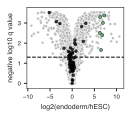

In [43]:
fig = plt.figure(figsize=(1.75, 1.5))

ncRNA = no_na[no_na["ctrl_status"] == "experimental"]
mRNA = no_na[no_na["ctrl_status"] == "control"]
de = no_na[no_na["ctrl_status"] == "mRNA"]

ncRNA_hits = ncRNA[ncRNA["is_hit"] == "hit"]
ctrl_hits = mRNA[mRNA["is_hit"] == "hit"]

ax = sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=no_na, fit_reg=False, 
                 color="darkgray", scatter_kws={"s": 8, "edgecolors": "white", "linewidths": 0.5})
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=ctrl_hits, fit_reg=False, 
            color=sns.color_palette()[2], scatter_kws={"s": 10, "edgecolors": "black", "linewidths": 0.5}, ax=ax)
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=ncRNA_hits, fit_reg=False, 
            color="black", scatter_kws={"s": 8, "edgecolors": "black", "linewidths": 0.5}, ax=ax)


plt.xlabel("log2(endoderm/hESC)")
plt.ylabel("negative log10 q value")
# plt.ylim((-0.1, 4))
# plt.xlim((-8.5, 8.5))
plt.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=1)
#plt.title("volcano plot for ncRNAs in endoderm vs. hESCs\n(n=%s)" % (len(diff_hESC_endo_ncRNA)))
#plt.savefig("Fig5J.pdf", bbox_inches="tight", dpi="figure")

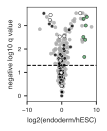

In [44]:
fig = plt.figure(figsize=(1.25, 1.75))

no_hits = no_na[no_na["is_hit"] == "stringent no hit"]

ncRNA_hits = ncRNA[ncRNA["is_hit"] == "hit"]
ctrl_hits = mRNA[mRNA["is_hit"] == "hit"]
de_hits = de[de["is_hit"] == "hit"]

ax = sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=no_hits, fit_reg=False, 
                 color="darkgray", scatter_kws={"s": 10, "edgecolors": "darkgray", "linewidths": 0.5})
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=ctrl_hits, fit_reg=False, 
            color=sns.color_palette()[2], scatter_kws={"s": 10, "edgecolors": "black", "linewidths": 0.5}, ax=ax)
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=ncRNA_hits, fit_reg=False, 
            color="black", scatter_kws={"s": 12, "edgecolors": "white", "linewidths": 0.5}, ax=ax)
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=de_hits, fit_reg=False, 
            color="white", scatter_kws={"s": 12, "edgecolors": "black", "linewidths": 0.5}, ax=ax)


plt.xlabel("log2(endoderm/hESC)")
plt.ylabel("negative log10 q value")
# plt.ylim((-0.1, 4))
plt.xlim((-10, 10))
plt.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=1)
fig.savefig("Fig5G.pdf", bbox_inches="tight", dpi="figure")

In [45]:
# fisher's exact (all biotypes)
tmp = no_na[no_na["is_hit"].isin(["stringent no hit", "hit"])]
tmp_node = tmp[tmp["qval_log10_hESC_endo"] <= -np.log10(0.05)]
tmp_de = tmp[tmp["qval_log10_hESC_endo"] > -np.log10(0.05)]

de_hit = len(tmp_de[tmp_de["is_hit"] == "hit"])
de_nohit = len(tmp_de[tmp_de["is_hit"] == "stringent no hit"])
node_hit = len(tmp_node[tmp_node["is_hit"] == "hit"])
node_nohit = len(tmp_node[tmp_node["is_hit"] == "stringent no hit"])

stats.fisher_exact([[de_hit, de_nohit], [node_hit, node_nohit]])

(1.2691560543924023, 0.3620219445880026)

In [46]:
# proportion of lncRNA hits w/in classes
tmp_node_lnc = tmp_node[tmp_node["ctrl_status"] == "experimental"]
tmp_de_lnc = tmp_de[tmp_de["ctrl_status"] == "experimental"]

node_lnc_hit = len(tmp_node_lnc[tmp_node_lnc["is_hit"] == "hit"])
node_lnc_nohit = len(tmp_node_lnc[tmp_node_lnc["is_hit"] == "stringent no hit"])
de_lnc_hit = len(tmp_de_lnc[tmp_de_lnc["is_hit"] == "hit"])
de_lnc_nohit = len(tmp_de_lnc[tmp_de_lnc["is_hit"] == "stringent no hit"])

p_hit_lnc_de = de_lnc_hit/(de_lnc_hit+de_lnc_nohit)
p_hit_lnc_node = node_lnc_hit/(node_lnc_hit+node_lnc_nohit)

print("%% of hits within differentially expressed lncRNAs: %s" % p_hit_lnc_de)
print("%% of hits within non-differentially expressed lncRNAs: %s" % p_hit_lnc_node)

% of hits within differentially expressed lncRNAs: 0.19327731092436976
% of hits within non-differentially expressed lncRNAs: 0.1902439024390244


## 8. write file

In [47]:
f = "../../../data/02__screen/02__enrichment_data/enrichment_values.with_rna_seq.UPDATED.txt"

In [48]:
data_w_seq.columns

Index(['group_id', 'ctrl_status', 'transcript_biotype_status',
       'CRISPhieRmix_FDR', 'effect_size', 'hit_status', 'n_sgRNA', 'tss_id',
       'gene_name', 'gene_id', 'transcript_name', 'transcript_id', 'csf',
       'cleaner_gene_biotype', 'cleaner_transcript_biotype', 'hESC_rep1',
       'hESC_rep2', 'endo_rep1', 'endo_rep2', 'meso_rep1', 'meso_rep2',
       'hESC_mean', 'endo_mean', 'threshold', 'qval_hESC_endo',
       'endo_hESC_log2fc', 'is_hit', 'endo_hESC_abslog2fc', 'neg_log_FDR'],
      dtype='object')

In [49]:
data_w_seq = data_w_seq[["group_id", "ctrl_status", "gene_name", "gene_id", "transcript_name",
                         "transcript_id", "cleaner_transcript_biotype", "cleaner_gene_biotype", "CRISPhieRmix_FDR", 
                         "is_hit", "effect_size",
                         "csf", "hESC_mean", "endo_mean", "qval_hESC_endo", "endo_hESC_log2fc",
                         "endo_hESC_abslog2fc"]]
data_w_seq.head()

,group_id,ctrl_status,gene_name,gene_id,transcript_name,transcript_id,cleaner_transcript_biotype,cleaner_gene_biotype,CRISPhieRmix_FDR,is_hit,effect_size,csf,hESC_mean,endo_mean,qval_hESC_endo,endo_hESC_log2fc,endo_hESC_abslog2fc
6,NC_000008.11:+:54457934,control,SOX17,ENSG00000164736.5_1,SOX17-001,ENST00000297316.4_1,protein_coding,protein_coding,0.0,hit,7.776623,protein_coding,0.110290,134.426513,0.000991006472787698,6.930430,6.930430
0,NC_000003.12:-:27722707,control,EOMES,ENSG00000163508.12_1,EOMES-004,ENST00000461503.2_1,protein_coding,protein_coding,0.0,hit,6.092888,protein_coding,0.123413,101.207791,0.0217931946808208,6.507473,6.507473
7,NC_000003.12:-:27722322,control,EOMES,ENSG00000163508.12_1,EOMES-001,ENST00000295743.8_1,protein_coding,protein_coding,0.0,hit,5.470160,protein_coding,0.084601,85.188250,0.000510199113682609,6.312255,6.312255
5,NC_000011.10:+:90223166,experimental,RP11-121L10.2,ENSG00000280367.1_1,RP11-121L10.2-001,ENST00000623330.1_1,promoter_overlap,promoter_overlap,0.0,hit,5.297966,lncRNA_good_csf,0.079364,0.114469,0.21018016578413398,0.046175,0.046175
2,NC_000023.11:-:11111137,experimental,RP11-120D5.1,ENSG00000234129.7_1,RP11-120D5.1-004,ENST00000608176.5_1,promoter_overlap,promoter_overlap,0.0,hit,4.142174,lncRNA_good_csf,0.233374,0.105861,0.131008798190622,-0.157441,0.157441


In [50]:
data_w_seq = data_w_seq.sort_values(by="effect_size", ascending=False)
data_w_seq.to_csv(f, sep="\t", index=False)

## 9. investigate expression of the 6 hits in cluster 1
FOXD3-AS1, LAMTOR5-AS1, VLDLR-AS1, HOXC-AS1, PBCP-AS1, LINC00623

In [51]:
data_w_seq.columns

Index(['group_id', 'ctrl_status', 'gene_name', 'gene_id', 'transcript_name',
       'transcript_id', 'cleaner_transcript_biotype', 'cleaner_gene_biotype',
       'CRISPhieRmix_FDR', 'is_hit', 'effect_size', 'csf', 'hESC_mean',
       'endo_mean', 'qval_hESC_endo', 'endo_hESC_log2fc',
       'endo_hESC_abslog2fc'],
      dtype='object')

In [52]:
tmp = data_w_seq[data_w_seq["gene_name"].isin(["FOXD3-AS1", "LAMTOR5-AS1", "VLDLR-AS1", "HOXC-AS1", "PCBP1-AS1",
                                               "LINC00623"])]
tmp = tmp[tmp["is_hit"] == "hit"]
tmp.sort_values(by=["endo_hESC_abslog2fc", "gene_name"], ascending=False)

,group_id,ctrl_status,gene_name,gene_id,transcript_name,transcript_id,cleaner_transcript_biotype,cleaner_gene_biotype,CRISPhieRmix_FDR,is_hit,effect_size,csf,hESC_mean,endo_mean,qval_hESC_endo,endo_hESC_log2fc,endo_hESC_abslog2fc
72,NC_000001.11:-:63323741,experimental,FOXD3-AS1,ENSG00000230798.5_1,FOXD3-AS1-004,ENST00000431294.5_1,promoter_overlap,transcript_overlap,0.026401,hit,0.439538,lncRNA_good_csf,2.815925,0.065131,0.0180047193533679,-1.841002,1.841002
57,NC_000009.12:-:2522018,experimental,VLDLR-AS1,ENSG00000236404.8_1,VLDLR-AS1-004,ENST00000447278.1_1,intergenic,transcript_overlap,0.001848,hit,0.434055,lncRNA_good_csf,3.715940,1.862828,0.0420305530901966,-0.720104,0.720104
88,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-022,ENST00000609709.5_1,promoter_overlap,transcript_overlap,0.099620,hit,2.095387,lncRNA_good_csf,0.170290,0.371025,0.38988373961177797,0.228390,0.228390
85,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-006,ENST00000587691.1_1,promoter_overlap,transcript_overlap,0.099620,hit,2.095387,lncRNA_good_csf,0.158044,0.333011,sleuth NA,0.202999,0.202999
89,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-023,ENST00000610148.5_1,promoter_overlap,transcript_overlap,0.099620,hit,2.095387,lncRNA_good_csf,0.135182,0.039498,sleuth NA,-0.127036,0.127036
84,NC_000002.12:-:70087802,experimental,PCBP1-AS1,ENSG00000179818.9,PCBP1-AS1-005,ENST00000413436.1,promoter_overlap,promoter_overlap,0.092215,hit,0.647201,lncRNA_good_csf,0.198609,0.277596,0.7050613819713549,0.092071,0.092071
87,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-014,ENST00000608253.1_1,promoter_overlap,transcript_overlap,0.099620,hit,2.095387,lncRNA_good_csf,0.533238,0.446500,0.17612973504964502,-0.084016,0.084016
90,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-031,ENST00000612551.4_1,promoter_overlap,transcript_overlap,0.099620,hit,2.095387,lncRNA_good_csf,0.697163,0.759826,0.238541776391718,0.052307,0.052307
49,NC_000001.11:+:120952589,experimental,LINC00623,ENSG00000235398.4,LINC00623-013,ENST00000457645.1,intergenic,transcript_overlap,0.000369,hit,1.296873,lncRNA_good_csf,0.227406,0.220316,1.0,-0.008359,0.008359
86,NC_000001.11:+:110407783,experimental,LAMTOR5-AS1,ENSG00000224699.8_1,LAMTOR5-AS1-020,ENST00000608067.5_1,promoter_overlap,transcript_overlap,0.099620,hit,2.095387,lncRNA_good_csf,0.000000,0.000000,sleuth NA,0.000000,0.000000


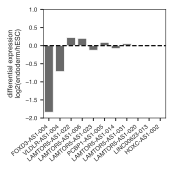

In [53]:
order = ["FOXD3-AS1-004", "VLDLR-AS1-004", "LAMTOR5-AS1-022", "LAMTOR5-AS1-006", "LAMTOR5-AS1-023",
         "PCBP1-AS1-005", "LAMTOR5-AS1-014", "LAMTOR5-AS1-031", "LAMTOR5-AS1-020", "LINC00623-013", "HOXC-AS1-002"]

fig = plt.figure(figsize=(2.2, 2))
ax = sns.barplot(data=tmp, x="transcript_name", y="endo_hESC_log2fc", order=order, color="dimgray")
ax.set_xlabel("")
ax.set_xticklabels(order, rotation=40, ha="right", va="top")
ax.set_ylabel("differential expression\nlog2(endoderm/hESC)")
ax.axhline(y=0, color="black", linestyle="dashed")
ax.set_ylim((-2, 1))

fig.savefig("Fig7A.pdf", dpi="figure", bbox_inches="tight")